# 1.  Importing Libraries:

In [382]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# 2. Extracting datafile from Zip folder

In [383]:
# # specifying the zip file name
# file_name = "./Data/ECA_blended_custom.zip"
  
# # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()
  
#     # extracting all the files
#     print('Extracting all files now...')
#     zip.extractall('./Data/ECA_blended_custom')
#     print('Done!')

# 3. Converting .txt file to .csv file

In [384]:
# read_file = pd.read_csv (r'./Data/ECA_blended_custom\TG_STAID002759.txt')
# read_file.to_csv (r'./Data/ECA_blended_custom\TG_STAID002759.csv', index=None)

# 4. Data Exploration and Cleaning

In [385]:
df = pd.read_csv('./TG_STAID002759.csv', sep=',', parse_dates=['DATE'])
df.head(2)

,SOUID,DATE,TG,Q_TG
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0


### 4.1 extrtacting 'year' from datetime 'DATE' columns

In [386]:
df['Year'] = df['DATE'].dt.year

### 4.2 rescaling temperature, since its scaled down to 1/10 of celcius.

In [387]:
df.TG = df.TG/10

# 5. Basic visualization

In [388]:
def TimeSeriesPlot(dataframe,x,y):
    """ this function plots timeseries"""
    dataframe.plot(x,y)
    plt.xlabel(x)
    plt.ylabel('Temperature')
    plt.show

### 5.1. calculating yearly average temp

In [389]:
yearly_avg = df.groupby(by = ['Year']).mean()
yearly_avg.reset_index(inplace= True)
yearly_avg.head()


,Year,SOUID,TG,Q_TG
0,1876,127488.0,9.320219,0.0
1,1877,127488.0,9.727945,0.0
2,1878,127488.0,10.236712,0.0
3,1879,127488.0,8.180548,0.0
4,1880,127488.0,9.805191,0.0


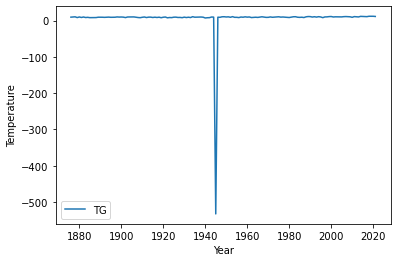

In [390]:
TimeSeriesPlot(yearly_avg, x = 'Year',y = 'TG')

### looks like there are some junk temperature val between 1940 to 1950

### 5.2. slicing the dataframe between 1940 -1950 to extract exact year of the junk temp value

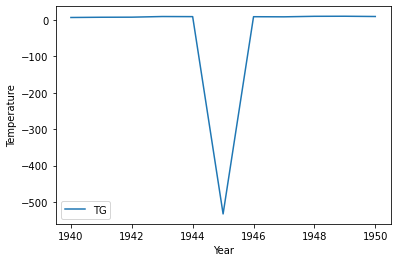

In [391]:
year_temp_missing = df[(df['Year'] >= 1940) & (df['Year'] <= 1950)]       # slicing dataframe from 1940-1950
temp_missing = year_temp_missing.groupby(['Year']).mean()                 # groupby dataframe by 'Year' 
temp_missing.reset_index(inplace=True)                                    
TimeSeriesPlot (temp_missing, x = 'Year', y = 'TG')

### Since the plot above represents average values of temp so we can now pinpoint at year 1945 as it has been filled with non practical values for temperature.

### 5.3. since the data has temperature from 1876 to 2021, Hence I will replace 1945 temperature 'TG' values previous 10year avg (1934 to 1944)

In [392]:
df['Month'] = df['DATE'].dt.month                         # extracting month from DATE col
monthly_grpby = df.groupby(by = ['Year','Month']).mean()  # grouping by 'Year' and 'Month'
monthly_grpby.reset_index(inplace=True)                   
monthly_grpby.head()

,Year,Month,SOUID,TG,Q_TG
0,1876,1,127488.0,-2.070968,0.0
1,1876,2,127488.0,2.389655,0.0
2,1876,3,127488.0,4.964516,0.0
3,1876,4,127488.0,9.833333,0.0
4,1876,5,127488.0,10.270968,0.0


#### 5.3.1.  taking an average of TG (temperature) from the year 1934 to 1944 and impute it to the year 1945 

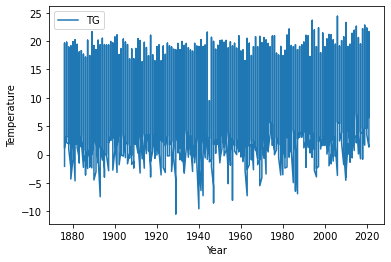

In [393]:
Avg_10_yeartemp = monthly_grpby[(monthly_grpby['Year'] >= 1934) & (monthly_grpby['Year'] <= 1944)]
Avg_10_yeartemp.groupby(by = ['Month']).mean()

monthly_grpby[(monthly_grpby['Year'] == 1945)] = monthly_grpby.replace(
                                                 monthly_grpby.loc[monthly_grpby['Year'] == 1945,'TG'].to_list(),
                                                 Avg_10_yeartemp.loc[Avg_10_yeartemp['Year'] == 1939,'TG'].to_list())

TimeSeriesPlot(monthly_grpby, x = 'Year',y = 'TG')

#### 5.3.2. Checking if the imputation for the year 1945 for TG val has been successful or not

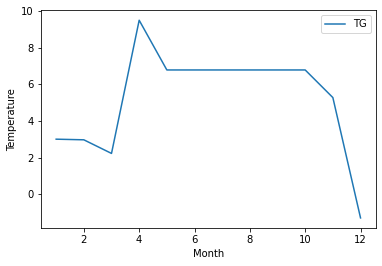

In [394]:
T_1945= monthly_grpby[monthly_grpby['Year'] == 1945]
T_1945.reset_index(inplace=True)
TimeSeriesPlot(T_1945, x = 'Month', y  ='TG')

### In the above plot we clearly see the imputation has been successful

In [395]:
monthly_grpby.head()

,Year,Month,SOUID,TG,Q_TG
0,1876,1,127488.0,-2.070968,0.0
1,1876,2,127488.0,2.389655,0.0
2,1876,3,127488.0,4.964516,0.0
3,1876,4,127488.0,9.833333,0.0
4,1876,5,127488.0,10.270968,0.0


# 6. Building Linear Regression Model:

### For building the linear regression model for modeling the trend , the data has been grouped to monthy data

### 6.1. Modeling the Trend
### Splitting the dataset into training and testing dataset and also introducing a new col called time steps

#### 6.1.1. Inserting a new col 'timesteps' 

In [396]:
monthly_grpby['timestep'] = range(len(monthly_grpby))
#monthly_grpby.head()

In [397]:
monthly_grpby.head()

,Year,Month,SOUID,TG,Q_TG,timestep
0,1876,1,127488.0,-2.070968,0.0,0
1,1876,2,127488.0,2.389655,0.0,1
2,1876,3,127488.0,4.964516,0.0,2
3,1876,4,127488.0,9.833333,0.0,3
4,1876,5,127488.0,10.270968,0.0,4


In [398]:
monthly_grpby.shape

(1751, 6)

#### 6.1.2. Splitting the dataset 'monthly_grpby' into dataframe 'X' and 'y'

In [399]:
X = monthly_grpby.drop(['SOUID','Month','Year','Q_TG','TG'], axis = 1)
y = monthly_grpby['TG']

#### 6.1.3 Splitting the data set for training and testing

In [400]:
X_train = X[:1500]
X_test = X[1500:]
y_train = y[:1500]
y_test = y[1500:]

### 6.2. Building Linear Regression Model

#### 6.2.1. Initializing and training linear regression model

In [401]:
m = LinearRegression().fit(X_train,y_train)
X_train['trend'] = m.predict(X_train)
#X_train.head()

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/3183440541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['trend'] = m.predict(X_train)


#### 6.2.2. Plot of timesteps versus trend (predicted value) for training data

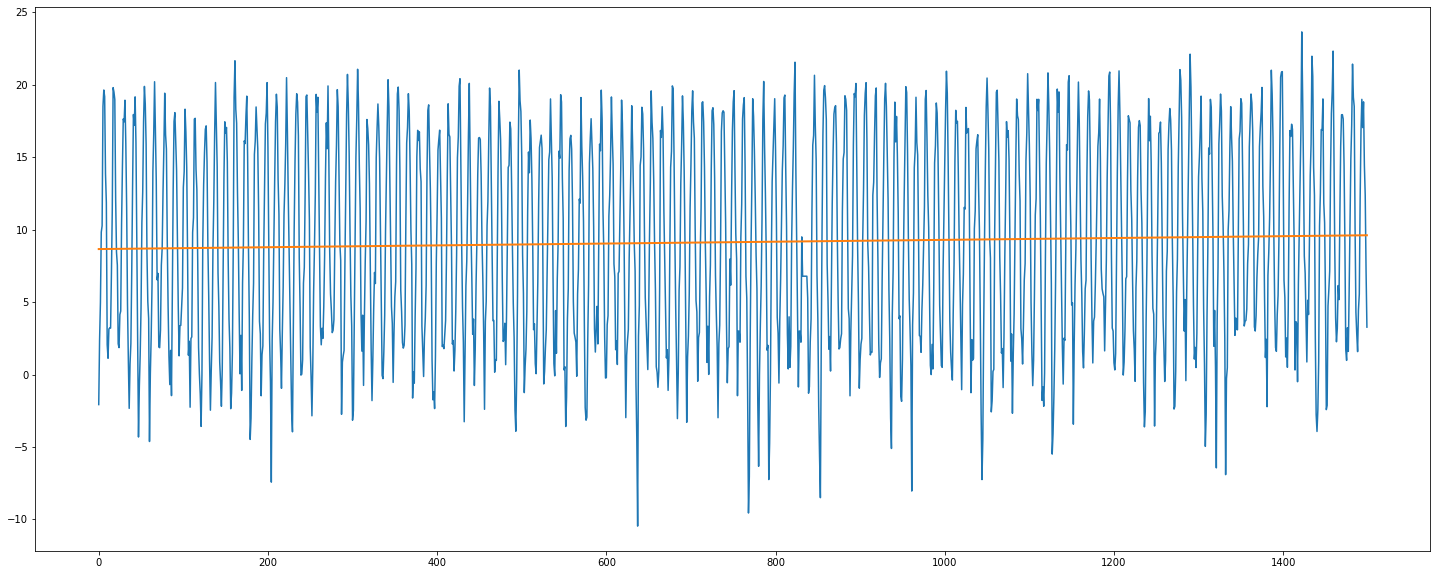

In [402]:
plt.figure(figsize=(25,10))
plt.plot(X_train['timestep'],y_train )
plt.plot(X_train['timestep'],X_train['trend'],label='trend', linewidth=2)

#### 6.2.3 Testing the model on the test data

In [403]:
X_test['trend'] = m.predict(X_test)

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/2438844416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['trend'] = m.predict(X_test)


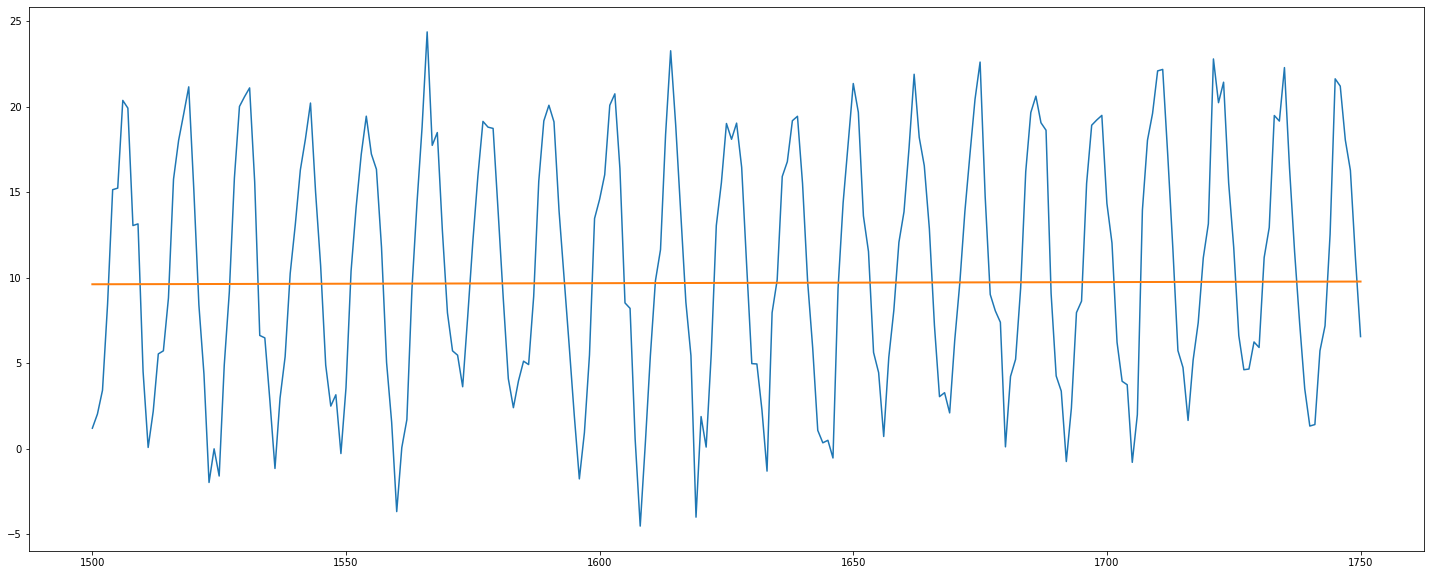

In [404]:
plt.figure(figsize=(25,10))
plt.plot(X_test['timestep'],y_test)
plt.plot(X_test['timestep'],X_test['trend'],label='trend', linewidth=2)

### 6.3. Modeling the seasonal parameters

#### 6.3.1 OneHotEncodling on Month col from monty_grpby dataframe

In [405]:
monthly_grpby.head(2)

,Year,Month,SOUID,TG,Q_TG,timestep
0,1876,1,127488.0,-2.070968,0.0,0
1,1876,2,127488.0,2.389655,0.0,1


In [406]:
Monthly_dummies = pd.get_dummies(
    data=monthly_grpby['Month'],
    prefix='Month',
    drop_first=True)

Monthly_dummies.head()

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


#### 6.3.2. joining the Monthly_dummies dataframe to monthly_grpby dataframe

In [407]:
monthly_grpby = monthly_grpby.join(Monthly_dummies)
monthly_grpby.head()

,Year,Month,SOUID,TG,Q_TG,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1876,1,127488.0,-2.070968,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,1876,2,127488.0,2.389655,0.0,1,1,0,0,0,0,0,0,0,0,0,0
2,1876,3,127488.0,4.964516,0.0,2,0,1,0,0,0,0,0,0,0,0,0
3,1876,4,127488.0,9.833333,0.0,3,0,0,1,0,0,0,0,0,0,0,0
4,1876,5,127488.0,10.270968,0.0,4,0,0,0,1,0,0,0,0,0,0,0


#### 6.3.3. Join X_train and X_train dataframe

In [408]:
X_full = pd.concat([X_train,X_test])
X_full.head(2)

,timestep,trend
0,0,8.663322
1,1,8.663957


#### 6.3.4. appending 'trend' col from X_full to monthly_grpby dataframe

In [409]:
monthly_grpby['trend'] = X_full['trend']
monthly_grpby.head(2)

,Year,Month,SOUID,TG,Q_TG,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend
0,1876,1,127488.0,-2.070968,0.0,0,0,0,0,0,0,0,0,0,0,0,0,8.663322
1,1876,2,127488.0,2.389655,0.0,1,1,0,0,0,0,0,0,0,0,0,0,8.663957


#### 6.3.5. Splitting the dataframe for training and testing

In [410]:
X_seasonal = monthly_grpby.drop(['Year','Month','SOUID','TG','Q_TG'], axis = 1)
y_seasonal = monthly_grpby['TG']
X_seasonal.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend
0,0,0,0,0,0,0,0,0,0,0,0,0,8.663322
1,1,1,0,0,0,0,0,0,0,0,0,0,8.663957


In [411]:
X_train_se = X_seasonal[:1500]
X_test_se = X_seasonal[1500:]
y_train_se = y_seasonal[:1500]
y_test_se = y_seasonal[1500:]

#### 6.3.6 Initializing the linear model

In [412]:
m_se = LinearRegression().fit(X_train_se,y_train_se)
y_tr_predict = m_se.predict(X_train_se)
X_train_se['Seasonal_trend'] = y_tr_predict
X_train_se.head(2)

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/3422503364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_se['Seasonal_trend'] = y_tr_predict


,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend
0,0,0,0,0,0,0,0,0,0,0,0,0,8.663322,-0.603944
1,1,1,0,0,0,0,0,0,0,0,0,0,8.663957,0.291181


#### 6.3.7. Plot of timesteps versus Seasonal_trend (predicted value) for training data

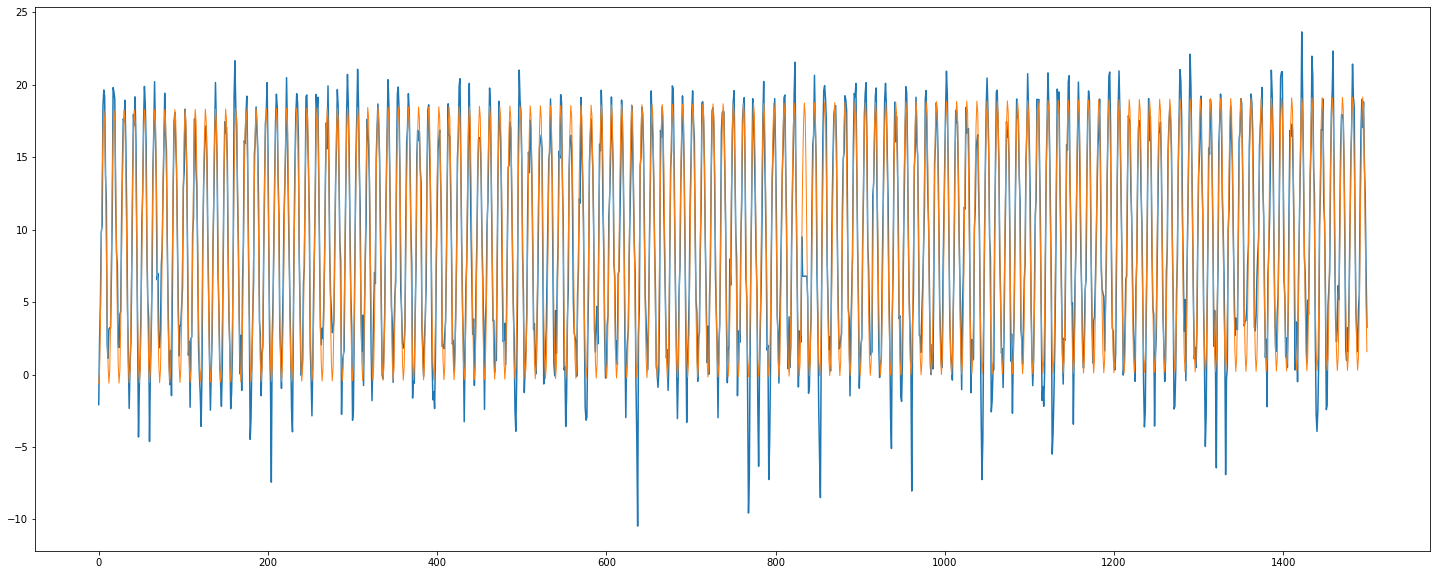

In [413]:
plt.figure(figsize=(25,10))
plt.plot(X_train_se['timestep'],y_train_se )
plt.plot(X_train_se['timestep'],X_train_se['Seasonal_trend'],label='Seasonal_trend', linewidth=1)

#### 6.3.8. Testing the model on the test data

In [414]:
y_te_predict = m_se.predict(X_test_se)
X_test_se['Seasonal_trend'] = y_te_predict
X_test_se.head(2)

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/2274896618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_se['Seasonal_trend'] = y_te_predict


,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend
1500,1500,0,0,0,0,0,0,0,0,0,0,0,9.616241,0.306869
1501,1501,1,0,0,0,0,0,0,0,0,0,0,9.616876,1.201995


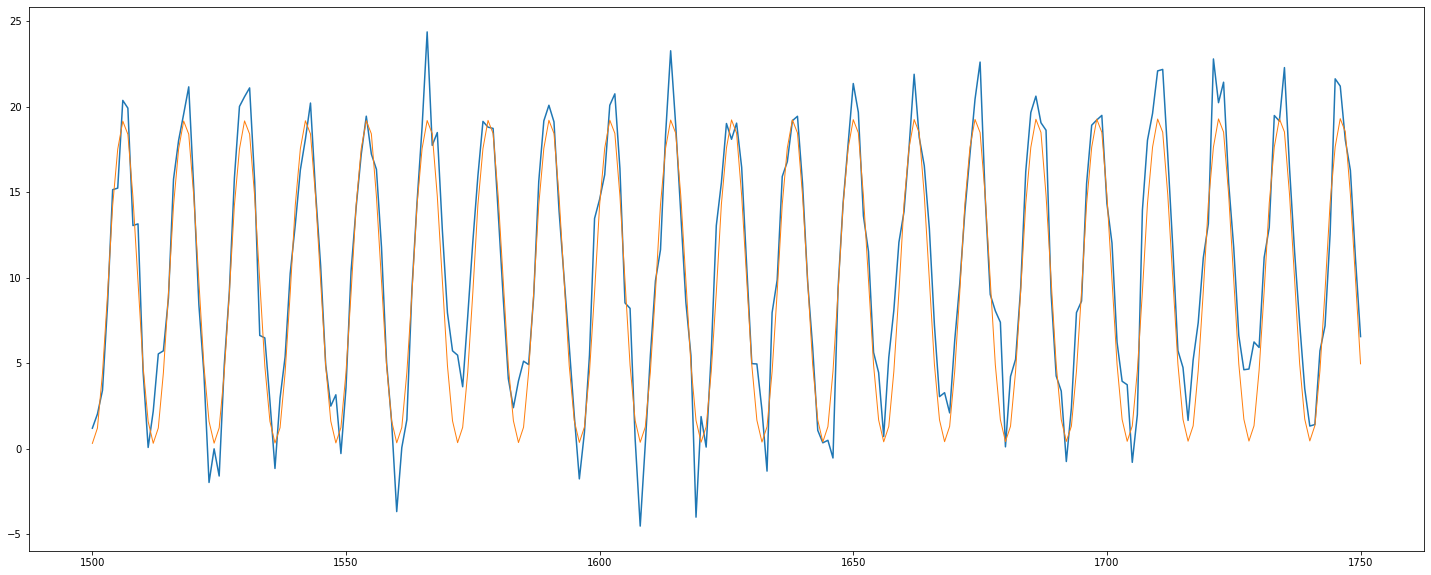

In [415]:
plt.figure(figsize=(25,10))
plt.plot(X_test_se['timestep'],y_test_se )
plt.plot(X_test_se['timestep'],X_test_se['Seasonal_trend'],label='Seasonal_trend', linewidth=1)

### 6.4. Building AR model for modeling the noise parameters

#### 6.4.1. concatinate X_test_se and X_train_se dataframe

In [416]:
X_full_se = pd.concat([X_train_se,X_test_se])
X_full_se.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend
0,0,0,0,0,0,0,0,0,0,0,0,0,8.663322,-0.603944
1,1,1,0,0,0,0,0,0,0,0,0,0,8.663957,0.291181


#### 6.4.2 Calculating remainder component of the timeseries by subtracting predicted Seasonal_trend col and y_seasonal

In [417]:
X_full_se['remainder'] = y_seasonal - X_full_se['Seasonal_trend']
X_full_se.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend,remainder
0,0,0,0,0,0,0,0,0,0,0,0,0,8.663322,-0.603944,-1.467024
1,1,1,0,0,0,0,0,0,0,0,0,0,8.663957,0.291181,2.098474


#### 6.4.3. Adding lag of remainder to the datarame X_full_se and dropping the first row as it will have a nan val after shifiting it with lag.

#### To calculate the lag, partial autocorrelation has to be calculated between lags

#### 6.4.3.1 Plot of AutoCoorelation

Text(0.5, 0, 'lags')

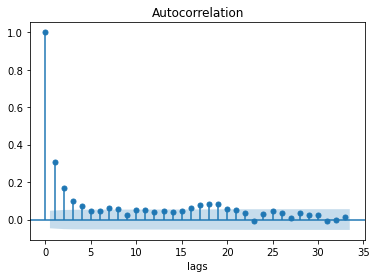

In [418]:
plot_acf(X_full_se['remainder'])
plt.xlabel('lags')

#### 6.4.3.2 Plot of Partial - AutoCoorelation

Text(0.5, 0, 'lags')

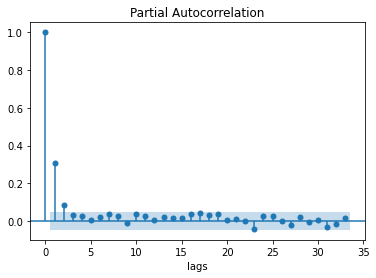

In [419]:
plot_pacf(X_full_se['remainder'])
plt.xlabel('lags')

### We will choose all lags until the first sharp drop in values. In this case we will have 2 lag. This is the point after which we know the correlation dropped significantly. This method is call "Box-Jenkins-Methodology"

In [420]:
X_full_se['lag'] = X_full_se['remainder'].shift(2)
X_full_se.dropna(inplace=True)
X_full_se.head()

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend,remainder,lag
2,2,0,1,0,0,0,0,0,0,0,0,0,8.664593,3.516856,1.447660,-1.467024
3,3,0,0,1,0,0,0,0,0,0,0,0,8.665228,8.159997,1.673337,2.098474
4,4,0,0,0,1,0,0,0,0,0,0,0,8.665863,13.303179,-3.032211,1.447660
5,5,0,0,0,0,1,0,0,0,0,0,0,8.666498,16.602239,1.901094,1.673337
6,6,0,0,0,0,0,1,0,0,0,0,0,8.667134,18.246430,1.395505,-3.032211


#### 6.4.4. removing the first row from the y_seasonal datadframe as it has to match with the X_full_se dataframe

In [421]:
#y_seasonal.drop(index=y_seasonal.index[0], axis=0, inplace=True)
y_seasonal = y_seasonal.iloc[2:]

#### 6.4.5. Splitting the dataset into training and testing dataset

In [422]:
X_train_AR = X_full_se[:1500]
X_test_AR = X_full_se[1500:]
y_train_AR = y_seasonal[:1500]
y_test_AR = y_seasonal[1500:]

#### 6.4.6. Initializing and training the model

In [423]:
m_AR = LinearRegression().fit(X_train_AR, y_train_AR)
X_train_AR['prediction_wlag'] = m_AR.predict(X_train_AR)

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/3373277253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_AR['prediction_wlag'] = m_AR.predict(X_train_AR)


#### 6.4.7. Plot of timesteps versus prediction_wlag (predicted value) for training data

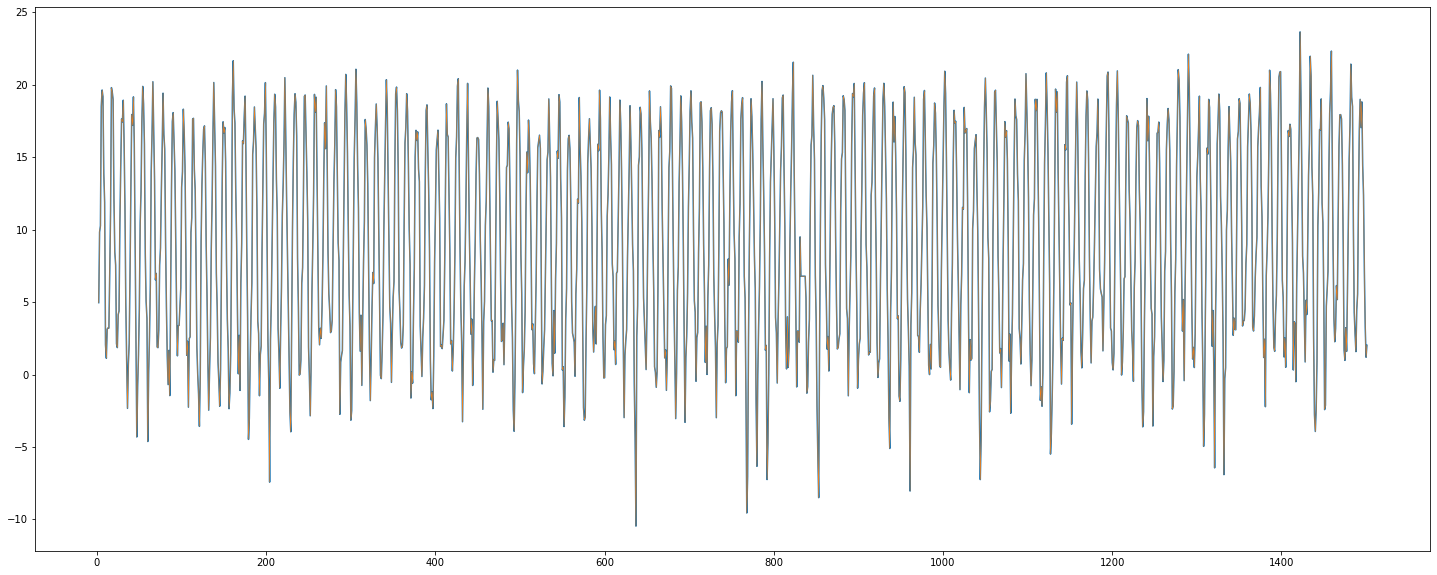

In [424]:
plt.figure(figsize=(25,10))
plt.plot(X_train_AR['timestep'],y_train_AR )
plt.plot(X_train_AR['timestep'],X_train_AR['prediction_wlag'],label='prediction_wlag', linewidth=0.5)

#### 6.4.8. Testing the model on the test data

In [425]:
X_test_AR['prediction_wlag'] = m_AR.predict(X_test_AR)

C:\Users\Asus\AppData\Local\Temp/ipykernel_33684/1735619384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_AR['prediction_wlag'] = m_AR.predict(X_test_AR)


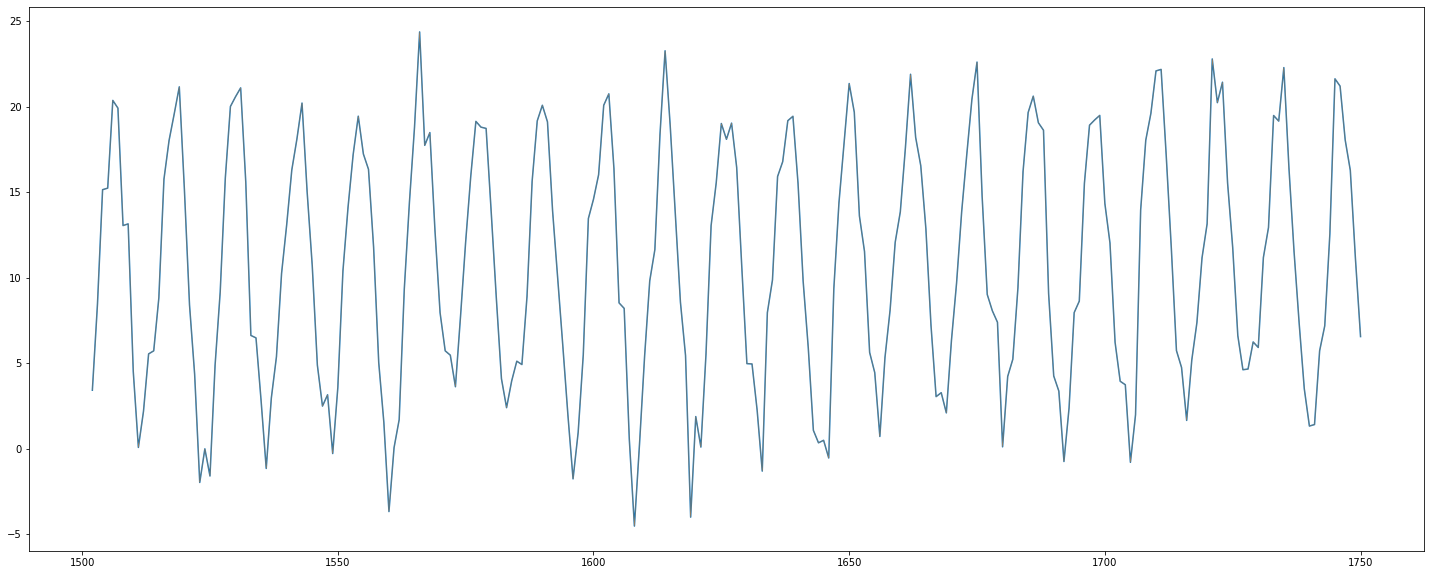

In [426]:
plt.figure(figsize=(25,10))
plt.plot(X_test_AR['timestep'],y_test_AR)
plt.plot(X_test_AR['timestep'],X_test_AR['prediction_wlag'],label='prediction_wlag', linewidth=0.25)

# 7. Cross Validation

#### 7.0.1 dropping all the predicted values from the dataframe X_train_AR

In [427]:
X_train_cv  = X_train_AR.drop(['trend','Seasonal_trend','remainder','prediction_wlag'], axis = 1)
X_train_cv.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag
2,2,0,1,0,0,0,0,0,0,0,0,0,-1.467024
3,3,0,0,1,0,0,0,0,0,0,0,0,2.098474


#### 7.0.2 Initializing and training the model using crossvalidation 

In [428]:
m_cv = LinearRegression()

TS_split = TimeSeriesSplit(n_splits= 5)

time_series_split = TS_split.split(X_train_cv, y_train_AR)

result = cross_val_score(estimator=m_cv, X= X_train_cv, y = y_train_AR, cv = time_series_split )

print(f'test_mean = {result.mean()}, test_std = {result.std()}')

test_mean = 0.9131213232468763, test_std = 0.019260456897367263


#### 7.0.3. testing the model 

In [429]:
X_test_cv = X_test_AR.drop(['trend','Seasonal_trend','remainder','prediction_wlag'], axis = 1)

In [430]:
m_cv.fit(X_train_cv,y_train_AR)
m_cv.fit(X_test_cv,y_test_AR)
y_pred_train_cv = m_cv.predict(X_train_cv)
y_pred_test_cv = m_cv.predict(X_test_cv)
m_cv.score(X_test_cv, y_test_AR)

0.9319949451026488

# 8. Forecasting

### 8.1 model the entire dataset 

#### 8.1.1. Join the dataset X_train_cv and Y_train_cv

In [434]:
X_full_mod = pd.concat([X_train_cv, X_test_cv])
X_full_mod.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag
2,2,0,1,0,0,0,0,0,0,0,0,0,-1.467024
3,3,0,0,1,0,0,0,0,0,0,0,0,2.098474


#### 8.1.2. Initializing the model and training it on the full dataset

In [435]:
m_combined = LinearRegression()
m_combined.fit(X_full_mod, y_seasonal)

LinearRegression()

### 8.2. creating the first time val in the future for prediction

#### 8.2.1. Concatinate the dataframe X_train_AR and X_test_AR wit pred_lag

In [438]:
X_full = pd.concat([X_train_AR, X_test_AR])
X_full.head(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend,remainder,lag,prediction_wlag
2,2,0,1,0,0,0,0,0,0,0,0,0,8.664593,3.516856,1.447660,-1.467024,4.964516
3,3,0,0,1,0,0,0,0,0,0,0,0,8.665228,8.159997,1.673337,2.098474,9.833333


In [439]:
X_full.tail(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,trend,Seasonal_trend,remainder,lag,prediction_wlag
1749,1749,0,0,0,0,0,0,0,0,1,0,0,9.774425,9.918896,1.203685,-0.477915,11.122581
1750,1750,0,0,0,0,0,0,0,0,0,1,0,9.775060,4.963313,1.593353,1.407111,6.556667


#### 8.2.2. Drop all the prediction except lag

In [440]:
X_full_fu= X_full.drop(['trend','Seasonal_trend','remainder','prediction_wlag'], axis = 1)

In [442]:
X_full_fu.tail(2)

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag
1749,1749,0,0,0,0,0,0,0,0,1,0,0,-0.477915
1750,1750,0,0,0,0,0,0,0,0,0,1,0,1.407111


In [441]:
m_full = LinearRegression().fit(X_full_fu, y_seasonal)

#### 8.2.3. Creating a single future step data

In [443]:
timestep = X_full['timestep'].max() + 1
months = [0] * 11
lag = X_full.loc[1750, 'remainder']    # extracting remainder val from location 1750 and adding it to lag col
timestep, months, lag

(1751, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1.593353377023055)

In [444]:
X_fut = [timestep]

In [445]:
X_fut.extend(months)

In [446]:
X_fut.append(lag)

In [447]:
X_fut

[1751, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.593353377023055]

In [448]:
X_fut = pd.DataFrame([X_fut])
X_fut.columns = X_full_fu.columns
X_fut

,timestep,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,lag
0,1751,0,0,0,0,0,0,0,0,0,0,0,1.593353


#### 8.2.4. prediction for timestep 1751

In [450]:
y_fut_pred = m_full.predict(X_fut)

In [451]:
print(y_fut_pred)

[1.10605147]
